In [1]:
from imports import *

# Energy baricenter

**Loading image built in the step 4**

In [2]:
image = np.load("/data/vidales/images/image_compressed_4comp_1411_nocorrected.npy")

In [3]:
print(np.shape(image))

(29417, 9, 36, 16)


**Loading variables**

In [7]:
table = pq.read_table('saved_archives/ophit_variables_y_nocorrected.parquet')
nuvT_c = ak.from_iter(table.column('nuvT_c').to_pylist())
dEpromx_f = ak.from_iter(table.column('dEpromx_f').to_pylist())
dEpromy_f = ak.from_iter(table.column('dEpromy_f').to_pylist())
dEpromz_f = ak.from_iter(table.column('dEpromz_f').to_pylist())
del table

**Loading variables that are filtered to eliminate events with more than 1 neutrino. We load the variable nuvX to distinguish in which TPC occurs the interaction**

In [ ]:
print(np.shape(image))
print(np.shape(dEpromx_f))

In [ ]:
assert np.shape(image)[0] == np.shape(dEpromx_f)[0]
assert np.shape(image)[0] == np.shape(dEpromy_f)[0]
assert np.shape(image)[0] == np.shape(dEpromz_f)[0]

In [10]:
y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[1832.7022871  -141.81035117  140.83112553   74.82157564]
 [1851.59823681 -128.18496115  158.65734985  187.35995061]
 [ 519.95393046 -109.6146554  -131.17913959   15.07603944]
 ...
 [ 889.15791959  122.74146747   88.72589418  287.34965045]
 [1346.44396473   -2.2859062   171.68138257  260.6528424 ]
 [ 642.10002491   36.9916876    78.19434956  251.45103767]]
(29417, 4)


In [11]:
from sklearn.preprocessing import MinMaxScaler
# Define the column indices you want to scale to [0, 1] and [-1, 1]
columns_0_to_1 = [0, 3]  # For example, columns 0 and 2 to scale to [0, 1]
columns_minus1_to_1 = [1, 2]  # For example, columns 1 and 3 to scale to [-1, 1]

# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 1 and 4 -> scaled to [0, 1] and columns 2 and 3 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 1 and 4 -> scaled to [0, 1] and columns 2 and 3 -> scaled to [-1, 1]):
[[ 0.95212353 -0.70468957  0.69152032  0.14665728]
 [ 0.96438208 -0.6369907   0.77910531  0.36768281]
 [ 0.10049139 -0.5447226  -0.64493855  0.02931696]
 ...
 [ 0.34000872  0.60975791  0.43551344  0.56406273]
 [ 0.63666839 -0.01145088  0.84309585  0.51163016]
 [ 0.17973243  0.18370308  0.38376916  0.4935578 ]]


**When you have negative values leakyRELU doesnt take into account negative and positve in the same way**

## Creation of train and test sets

In [9]:
test_size = int(np.floor(0.30*np.shape(y_np)[0]) )
print(test_size)

8825


In [10]:
x_train, x_test = image[:-test_size], image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (20592, 9, 36, 16)
x_test dim.: (8825, 9, 36, 16)


In [17]:
y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

**Model architecture**

In [12]:
def create_cnn_model(x_train, conv_dim, maxpool_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Fifth convolutional block
    model = layers.Conv2D(512, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    #model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    
    # Output layer
    output_layer = layers.Dense(4, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [18]:
model = create_cnn_model(x_train, (3,3),(2,2))

/home/vidales/.local/lib/python3.9/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


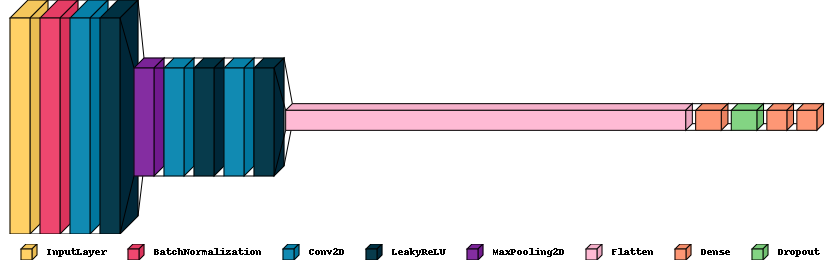

In [38]:
visualkeras.layered_view(model, legend=True,scale_xy=6, to_file='output.png')  # font is optional!

In [19]:
y_pred_scaling, history_scaling= train_and_predict(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=16)

Epoch 1/100
1287/1287 [==============================] - 6s 4ms/step - loss: 0.1112 - mse: 0.1112 - val_loss: 0.0493 - val_mse: 0.0493 - lr: 0.0010
Epoch 2/100
1287/1287 [==============================] - 5s 4ms/step - loss: 0.0622 - mse: 0.0622 - val_loss: 0.0406 - val_mse: 0.0406 - lr: 0.0010
Epoch 3/100
1287/1287 [==============================] - 5s 4ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0346 - val_mse: 0.0346 - lr: 0.0010
Epoch 4/100
1287/1287 [==============================] - 5s 4ms/step - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0269 - val_mse: 0.0269 - lr: 0.0010
Epoch 5/100
1287/1287 [==============================] - 4s 3ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0272 - val_mse: 0.0272 - lr: 0.0010
Epoch 6/100
1287/1287 [==============================] - 5s 4ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0244 - val_mse: 0.0244 - lr: 0.0010
Epoch 7/100
1287/1287 [==============================] - 5s 4ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.

In [13]:
y_pred, history= train_and_predict(model, x_train, y_train, x_test, y_test, epochs=40, batch_size=16)

Epoch 1/40
1104/1104 [==============================] - 9s 6ms/step - loss: 47874.5234 - mse: 47874.5234 - val_loss: 20609.8340 - val_mse: 20609.8340 - lr: 0.0010
Epoch 2/40
1104/1104 [==============================] - 6s 5ms/step - loss: 28676.7539 - mse: 28676.7539 - val_loss: 19752.2324 - val_mse: 19752.2324 - lr: 0.0010
Epoch 3/40
1104/1104 [==============================] - 7s 6ms/step - loss: 21756.7559 - mse: 21756.7559 - val_loss: 10130.1055 - val_mse: 10130.1055 - lr: 0.0010
Epoch 4/40
1104/1104 [==============================] - 6s 5ms/step - loss: 18522.2031 - mse: 18522.2031 - val_loss: 9486.7236 - val_mse: 9486.7236 - lr: 0.0010
Epoch 5/40
1104/1104 [==============================] - 7s 6ms/step - loss: 17379.0176 - mse: 17379.0176 - val_loss: 8301.5186 - val_mse: 8301.5186 - lr: 0.0010
Epoch 6/40
1104/1104 [==============================] - 6s 5ms/step - loss: 16394.3594 - mse: 16394.3594 - val_loss: 6903.6606 - val_mse: 6903.6606 - lr: 0.0010
Epoch 7/40
1104/1104 [======

In [14]:
print(y_test[1])
print(y_pred[1])

[1332.16265712  171.94207557 -182.40474202  398.44117908]
[1227.6959   172.71077 -200.47148  473.33405]


In [47]:
testScoreMSE_nuvT = mean_squared_error(y_test[:,0], y_pred_scaling[:,0])
testScoreMSE_X = mean_squared_error(y_test[:,1], y_pred_scaling[:,1])
testScoreMSE_Y = mean_squared_error(y_test[:,2], y_pred_scaling[:,2])
testScoreMSE_Z = mean_squared_error(y_test[:,3], y_pred_scaling[:,3])
print('MSE_nuvT: %.4f' % np.sqrt((testScoreMSE_nuvT)))
print('MSE_X: %.4f' % np.sqrt((testScoreMSE_X)))
print('MSE_Y: %.4f' % np.sqrt((testScoreMSE_Y)))
print('MSE_Z: %.4f' % np.sqrt((testScoreMSE_Z)))

MSE_nuvT: 0.1119
MSE_X: 0.1502
MSE_Y: 0.1496
MSE_Z: 0.0863


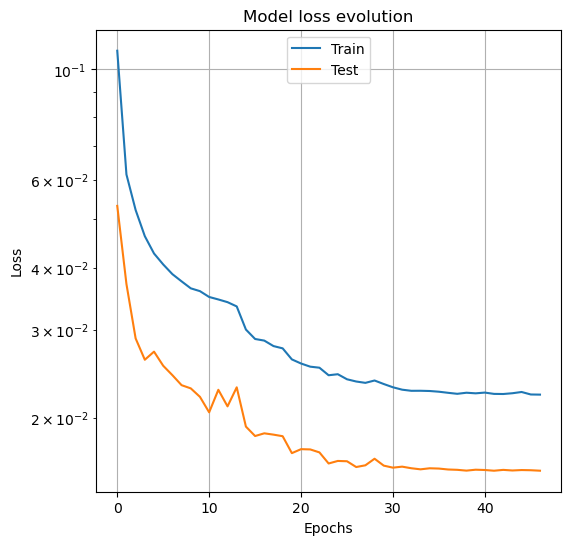

In [16]:
# Plot for the first model history
plt.figure(1, figsize=(6,6))
plt.plot(history_scaling.history['mse'])
plt.plot(history_scaling.history['val_mse'])
plt.yscale("log")
plt.title('Model loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Test'], loc='upper center')

# Show both figures
plt.show()


**with scaling**

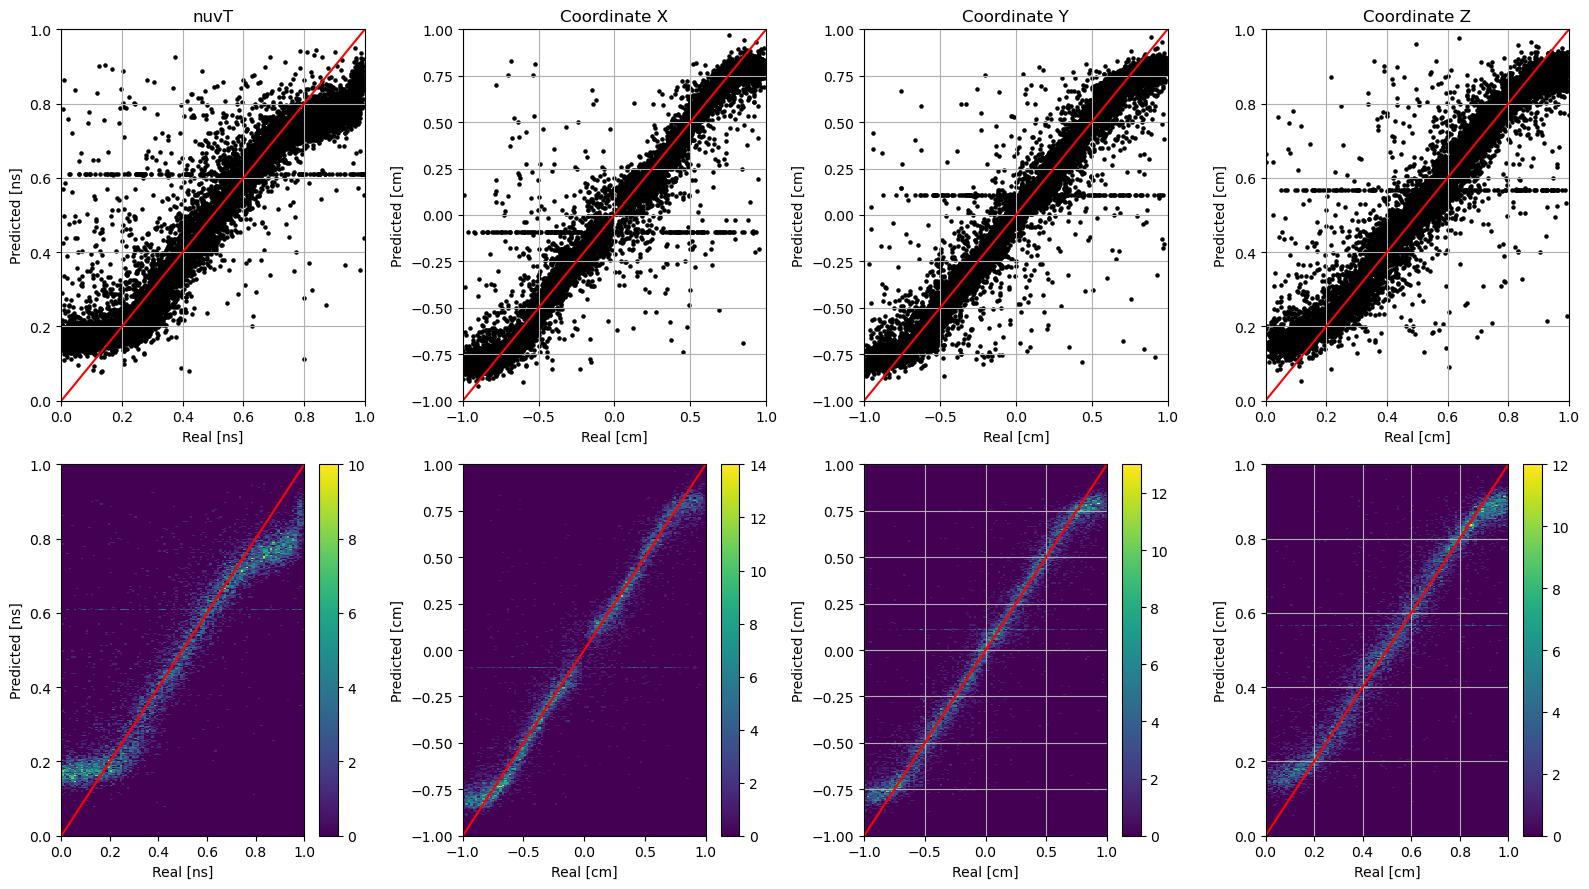

In [51]:
fig, axs = plt.subplots(2,4,figsize=(16,9))


axs[0,0].scatter(y_test[:,0], y_pred_scaling[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([0,1],[0,1],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([0,1])
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')



im1 = axs[1,0].hist2d(y_test[:,0], y_pred_scaling[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([0,1],[0,1],'r')
axs[1,0].set_xlim([0,1])
axs[1,0].set_ylim([0,1])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test[:,1], y_pred_scaling[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-1,1],[-1,1],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-1,1])
axs[0,1].set_ylim([-1,1])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')



im1 = axs[1,1].hist2d(y_test[:,1], y_pred_scaling[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,0].grid()

axs[1,1].plot([-1,1],[-1,1],'r')
axs[1,1].set_xlim([-1,1])
axs[1,1].set_ylim([-1,1])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')



axs[0,2].scatter(y_test[:,2], y_pred_scaling[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([-1,1],[-1,1],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-1,1])
axs[0,2].set_ylim([-1,1])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test[:,2], y_pred_scaling[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-1,1],[-1,1],'r')
axs[1,2].set_xlim([-1,1])
axs[1,2].set_ylim([-1,1])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test[:,3], y_pred_scaling[:,3], color="black",s=5)
axs[0,3].grid()

axs[0,3].plot([0,1],[0,1],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,1])
axs[0,3].set_ylim([0,1])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test[:,3], y_pred_scaling[:,3].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,1])
axs[1,3].set_ylim([0,1])
axs[1,3].plot([0,1],[0,1], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

**no scaling**

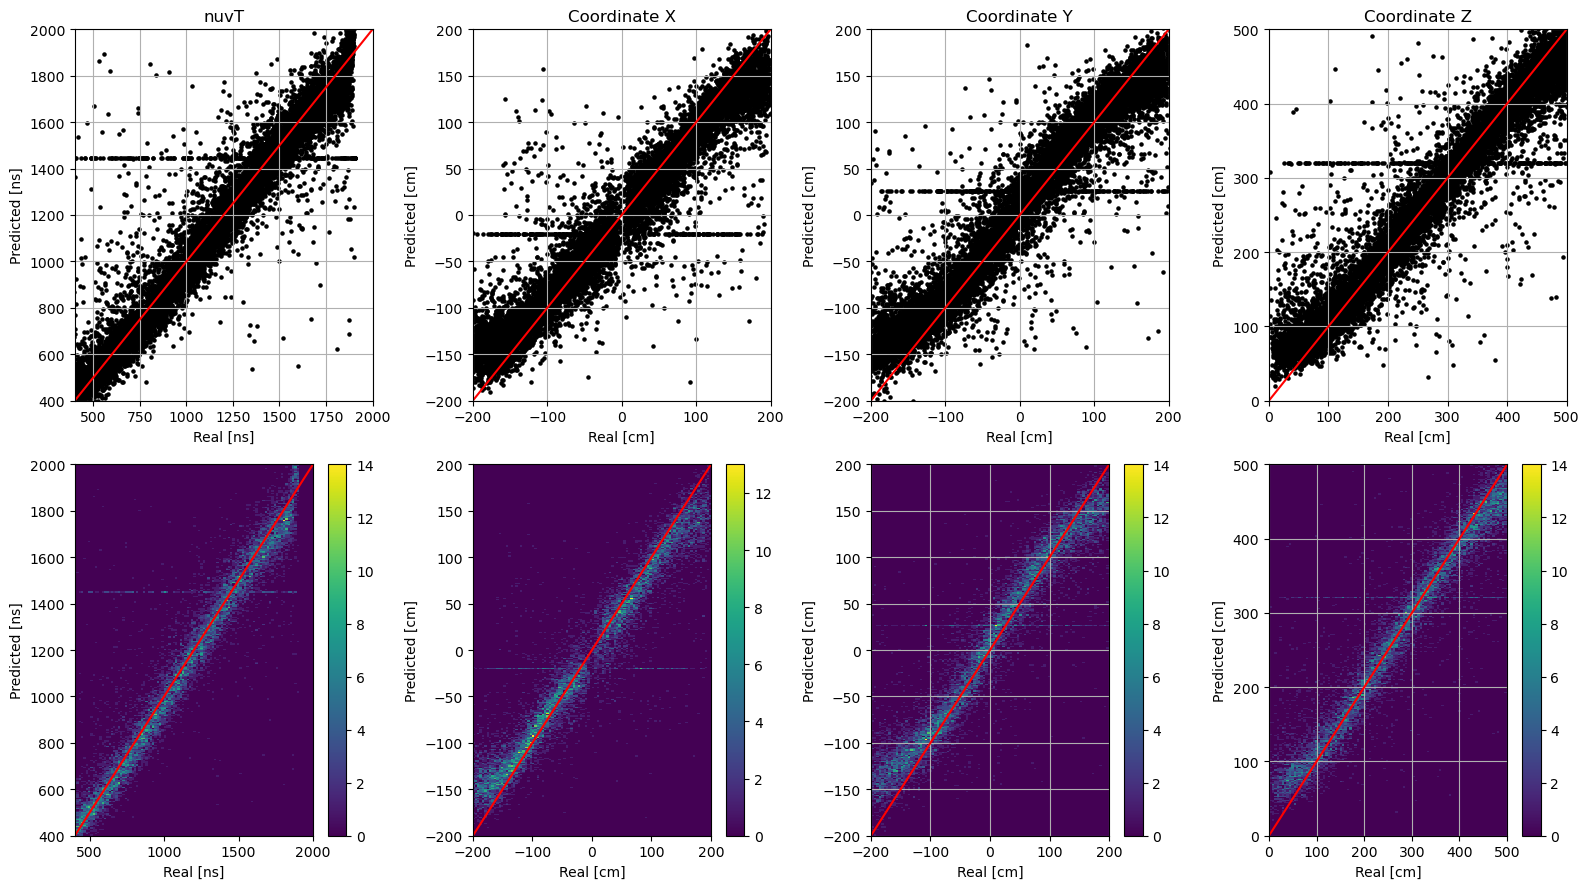

In [17]:
fig, axs = plt.subplots(2,4,figsize=(16,9))


axs[0,0].scatter(y_test[:,0], y_pred[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([200,2500],[200,2500],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([400,2000])
axs[0,0].set_ylim([400,2000])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')



im1 = axs[1,0].hist2d(y_test[:,0], y_pred[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([200,2500],[200,2500],'r')
axs[1,0].set_xlim([400,2000])
axs[1,0].set_ylim([400,2000])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test[:,1], y_pred[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')



im1 = axs[1,1].hist2d(y_test[:,1], y_pred[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,0].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')



axs[0,2].scatter(y_test[:,2], y_pred[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([-200,200],[-200,200],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-200,200])
axs[0,2].set_ylim([-200,200])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test[:,2], y_pred[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-200,200],[-200,200],'r')
axs[1,2].set_xlim([-200,200])
axs[1,2].set_ylim([-200,200])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test[:,3], y_pred[:,3], color="black",s=5)
axs[0,3].grid()

axs[0,3].plot([0,500],[0,500],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,500])
axs[0,3].set_ylim([0,500])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test[:,3], y_pred[:,3].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,500])
axs[1,3].set_ylim([0,500])
axs[1,3].plot([0,500],[0,500], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

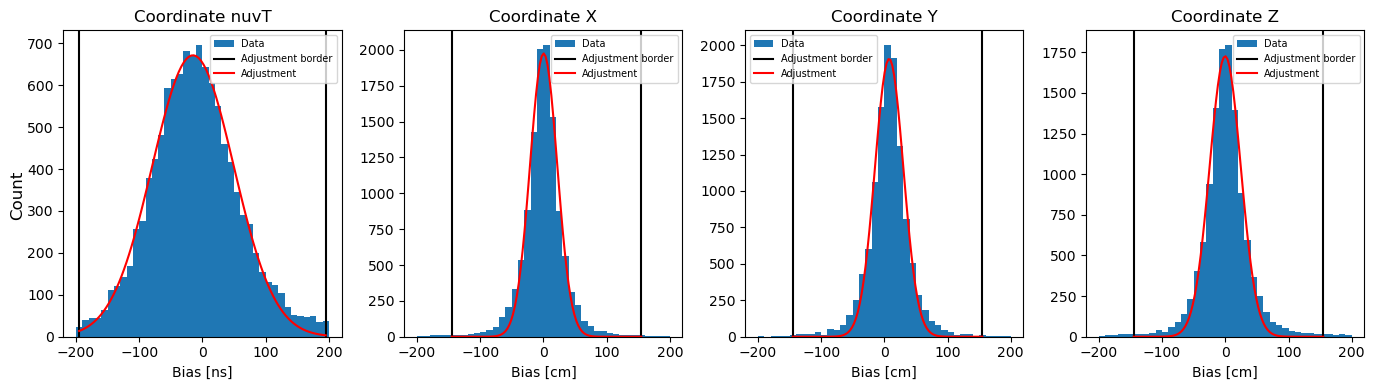

Bias Adjustment variables
------------------
Mean nuvT = -14.95
Sigma nuvT = 64.49
------------------
Mean X = 0.39
Sigma X = 21.54
------------------
Mean Y = 7.58
Sigma Y = 22.54
------------------
Mean Z = -0.22
Sigma Z = 24.64
------------------


In [22]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = y_pred[:, 0].flatten() - y_test[:, 0]
diffX = y_pred[:, 1].flatten() - y_test[:, 1]
diffY = y_pred[:, 2].flatten() - y_test[:, 2]
diffZ = y_pred[:, 3].flatten() - y_test[:, 3]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Function to fit and plot each histogram
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin):
    counts, bins, patches = axs[index].hist(diff, 40, range=[-200, 200], label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1])
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Fit and plot for each coordinate
popt_nuvT = fit_and_plot_hist(diffnuvT, axs, 0, 'nuvT', 0, 40)
popt_X = fit_and_plot_hist(diffX, axs, 1, 'X', 5, 35)
popt_Y = fit_and_plot_hist(diffY, axs, 2, 'Y', 5, 35)
popt_Z = fit_and_plot_hist(diffZ, axs, 3, 'Z', 5, 35)


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


## Visualize intermediate layers

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


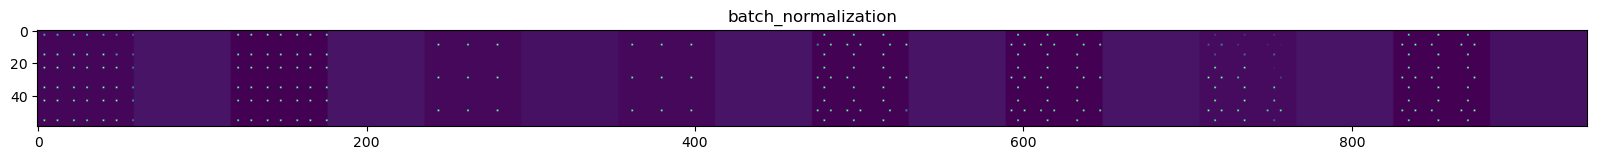

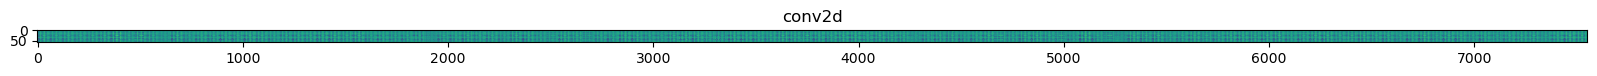

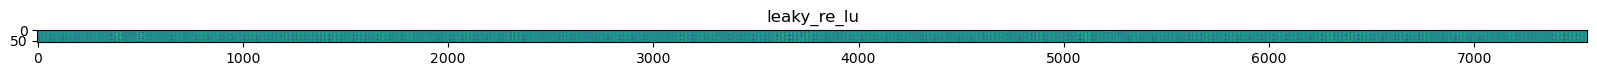

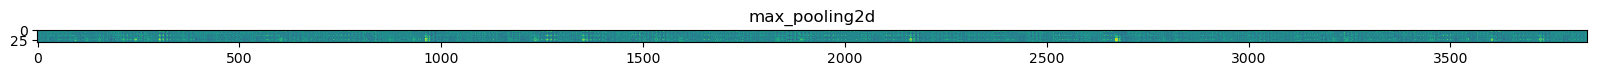

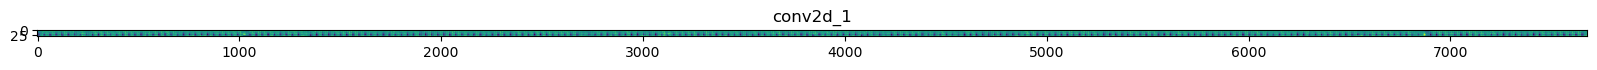

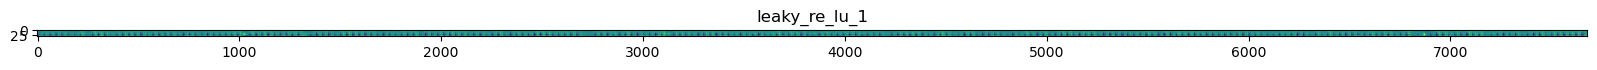

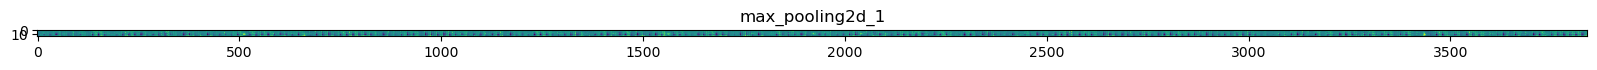

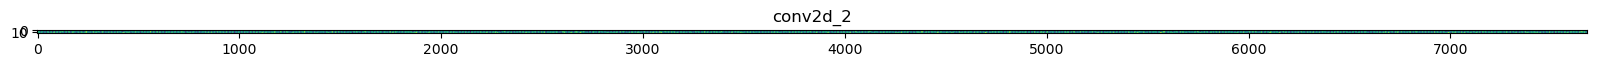

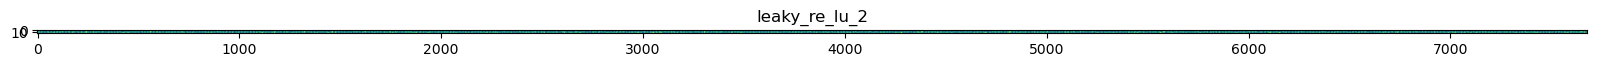

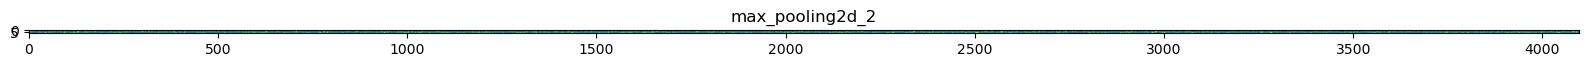

In [25]:
visualize_intermediate_layers(model_4compreal, x_train)

## Pruebas RESNET

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    """
    A residual block for ResNet.
    
    Arguments:
    x -- input tensor
    filters -- number of filters in the convolutional layer
    kernel_size -- size of the convolution kernel
    stride -- stride for the convolution
    
    Returns:
    x -- output tensor with the residual connection added
    """
    # Save the input tensor to add to the output later (skip connection)
    shortcut = x
    
    # If the number of filters changes, apply a 1x1 convolution to the shortcut
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut (skip connection) to the output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x


def create_resnet50_model(x_train, num_outputs=4):
    """
    Creates a ResNet-50 model with residual connections.
    
    Arguments:
    x_train -- input data to determine the input shape
    num_outputs -- number of outputs for the final dense layer (default is 4)
    
    Returns:
    model -- compiled ResNet-50 model
    """
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])  # (9, 36, 16)
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)
    
    # Initial Conv Layer (Standard Conv Layer before the ResNet blocks)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Add Residual Blocks (Total of 50 layers means stacking 16 residual blocks)
    x = residual_block(x, 64)  # Residual Block 1
    x = residual_block(x, 128)  # Residual Block 2
    x = residual_block(x, 256)  # Residual Block 3
    x = residual_block(x, 512)  # Residual Block 4
    
    # Global Average Pooling to reduce the spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layer
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    output_layer = layers.Dense(num_outputs, activation='linear')(x)
    
    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    return model

In [3]:
image = np.load("/data/vidales/images/image_realistic_4comp_1411_nocorrected.npy")

In [5]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras import models

# Define the input shape (224x224 RGB images)
input_shape = (59, 70, 16)

# Create the model using the pre-trained ResNet-50
model = tf.keras.applications.ResNet50(
    include_top=False,  # Do not include the final fully connected layers
    weights=None,  # Load pre-trained weights from ImageNet
    input_shape=input_shape  # Specify the input shape
)

# Add custom layers on top of ResNet-50 (optional, for transfer learning)
x = layers.GlobalAveragePooling2D()(model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(4, activation='linear')(x)  # Example for a 10-class classification task


# Final model
final_model = models.Model(inputs=model.input, outputs=x)

# Compile the model
final_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/applications/resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 16 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [13]:
test_size = int(np.floor(0.30*np.shape(y_scaled_combined)[0]) )
print(test_size)

8825


In [14]:
x_train, x_test = image[:-test_size], image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)
y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

x_train dim.: (20592, 59, 70, 16)
x_test dim.: (8825, 59, 70, 16)


In [15]:
y_pred_resnet, history_resnet= train_and_predict(final_model, x_train, y_train, x_test, y_test, epochs=20, batch_size=16)

2024-11-19 20:06:50.167357: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.
2024-11-19 20:06:54.587929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.


Epoch 1/20
1286/1287 [============================>.] - ETA: 0s - loss: 0.3371 - mse: 0.3371

/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1287/1287 [==============================] - 72s 51ms/step - loss: 0.3370 - mse: 0.3370 - val_loss: 0.1335 - val_mse: 0.1335 - lr: 0.0010
Epoch 2/20
1287/1287 [==============================] - 60s 47ms/step - loss: 0.1488 - mse: 0.1488 - val_loss: 0.1341 - val_mse: 0.1341 - lr: 0.0010
Epoch 3/20
1287/1287 [==============================] - 60s 47ms/step - loss: 0.1368 - mse: 0.1368 - val_loss: 0.1134 - val_mse: 0.1134 - lr: 0.0010
Epoch 4/20
1287/1287 [==============================] - 60s 47ms/step - loss: 0.1200 - mse: 0.1200 - val_loss: 0.1065 - val_mse: 0.1065 - lr: 0.0010
Epoch 5/20
1287/1287 [==============================] - 59s 46ms/step - loss: 0.1040 - mse: 0.1040 - val_loss: 0.1314 - val_mse: 0.1314 - lr: 0.0010
Epoch 6/20
1287/1287 [==============================] - 65s 51ms/step - loss: 0.0866 - mse: 0.0866 - val_loss: 0.0971 - val_mse: 0.0971 - lr: 0.0010
Epoch 7/20
1287/1287 [==============================] - 60s 47ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.0828

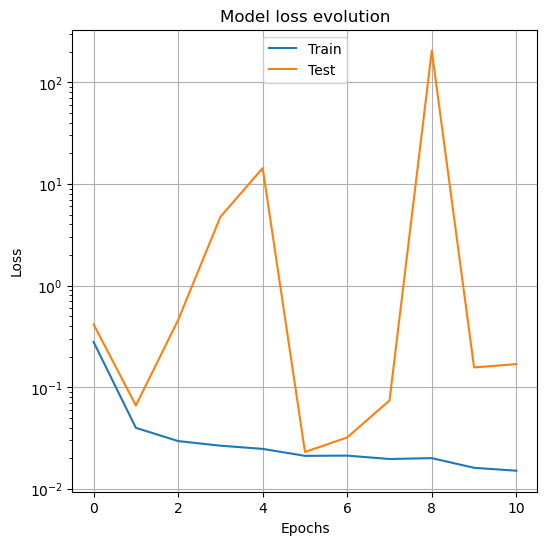

In [63]:
# Plot for the first model history
plt.figure(1, figsize=(6,6))
plt.plot(history_resnet.history['mse'])
plt.plot(history_resnet.history['val_mse'])
plt.yscale("log")
plt.title('Model loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Test'], loc='upper center')

# Show both figures
plt.show()


In [64]:
testScoreMSE_nuvT = mean_squared_error(y_test[:,0], y_pred_resnet[:,0])
testScoreMSE_X = mean_squared_error(y_test[:,1], y_pred_resnet[:,1])
testScoreMSE_Y = mean_squared_error(y_test[:,2], y_pred_resnet[:,2])
testScoreMSE_Z = mean_squared_error(y_test[:,3], y_pred_resnet[:,3])
print('MSE_nuvT: %.4f' % np.sqrt((testScoreMSE_nuvT)))
print('MSE_X: %.4f' % np.sqrt((testScoreMSE_X)))
print('MSE_Y: %.4f' % np.sqrt((testScoreMSE_Y)))
print('MSE_Z: %.4f' % np.sqrt((testScoreMSE_Z)))

MSE_nuvT: 0.1184
MSE_X: 0.1815
MSE_Y: 0.1923
MSE_Z: 0.0898


### Prueba red neuronal con diferentes capas

In [17]:
with open('multiple_histories.json', 'r') as file:
    loaded_histories = json.load(file)

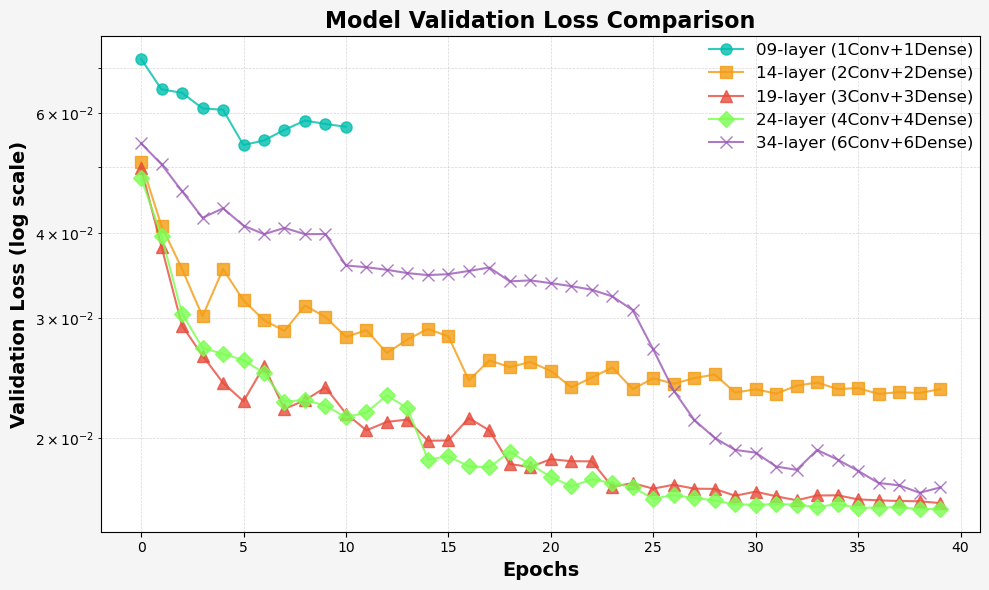

In [18]:
import matplotlib.pyplot as plt

# Access each model's history
model1_history = loaded_histories[0]['model1']
model2_history = loaded_histories[1]['model2']
model3_history = loaded_histories[2]['model3']
model4_history = loaded_histories[3]['model4']  
model5_history = loaded_histories[4]['model5']  

# Plotting the validation loss for all models
plt.figure(figsize=(10, 6))

# Plot each model's validation loss with smooth lines, subtle markers, and refined styling
plt.plot(model1_history['val_loss'], label='09-layer (1Conv+1Dense)', color='#00bfae', linestyle='-', marker='o', markersize=8, alpha=0.8)
plt.plot(model2_history['val_loss'], label='14-layer (2Conv+2Dense)', color='#f39c12', linestyle='-', marker='s', markersize=8, alpha=0.8)
plt.plot(model3_history['val_loss'], label='19-layer (3Conv+3Dense)', color='#e74c3c', linestyle='-', marker='^', markersize=8, alpha=0.8)
plt.plot(model4_history['val_loss'], label='24-layer (4Conv+4Dense)', color='#7aff50', linestyle='-', marker='D', markersize=8, alpha=0.8)
plt.plot(model5_history['val_loss'], label='34-layer (6Conv+6Dense)', color='#9b59b6', linestyle='-', marker='x', markersize=8, alpha=0.8)

# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Validation Loss Comparison', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


### Prueba con las dos representaciones

In [2]:
def cnn_tworep(x_train, conv_dim, stride_dim):

    from tensorflow.keras import layers, models
    
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same', strides=stride_dim)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    

    # Third convolutional block
    model = layers.Conv2D(128, (3,3), padding='same', strides=stride_dim)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)


    # Fourth convolutional block
    model = layers.Conv2D(256, (3,3), padding='same', strides=stride_dim)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
   
    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    
    # Output layer
    output_layer = layers.Dense(4, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [3]:
image_compressed = np.load("/data/vidales/images/image_compressed_4comp_1411_nocorrected.npy")
image_realistic = np.load("/data/vidales/images/image_realistic_4comp_1411_nocorrected.npy")

In [4]:
print(np.shape(image_compressed))
print(np.shape(image_realistic))

(29417, 9, 36, 16)
(29417, 59, 70, 16)


In [14]:
test_size = int(np.floor(0.30*np.shape(y_np)[0]) )
print(test_size)

8825


In [13]:
x_train_realistic, x_test_realistic = image_realistic[:-test_size], image_realistic[-test_size:]
x_train_compressed, x_test_compressed = image_compressed[:-test_size], image_compressed[-test_size:]

every PDS box in compressed rep is (3x9) and in realistic rep (13x11, not included spaces)

In [15]:
model_realistic = cnn_tworep(x_train_realistic, (13,11),2)
model_compressed = cnn_tworep(x_train_compressed, (3,9),1)

In [19]:
y_pred_realistic, history_realistic= train_and_predict(model_realistic, x_train_realistic, y_train, x_test_realistic, y_test, epochs=40, batch_size=16)

2024-11-20 19:27:06.551701: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.
2024-11-20 19:27:10.683675: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.


Epoch 1/40
1287/1287 [==============================] - 18s 13ms/step - loss: 0.1482 - mse: 0.1482 - val_loss: 0.0661 - val_mse: 0.0661 - lr: 0.0010
Epoch 2/40
1287/1287 [==============================] - 13s 10ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0607 - val_mse: 0.0607 - lr: 0.0010
Epoch 3/40
1287/1287 [==============================] - 13s 10ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0489 - val_mse: 0.0489 - lr: 0.0010
Epoch 4/40
1287/1287 [==============================] - 12s 10ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0510 - val_mse: 0.0510 - lr: 0.0010
Epoch 5/40
1287/1287 [==============================] - 13s 10ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0278 - val_mse: 0.0278 - lr: 0.0010
Epoch 6/40
1287/1287 [==============================] - 13s 10ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0262 - val_mse: 0.0262 - lr: 0.0010
Epoch 7/40
1287/1287 [==============================] - 13s 10ms/step - loss: 0.0406 - mse: 0.0406 - val_l

In [18]:
y_pred_compressed, history_compressed= train_and_predict(model_compressed, x_train_compressed, y_train, x_test_compressed, y_test, epochs=40, batch_size=16)

Epoch 1/40
1287/1287 [==============================] - 14s 9ms/step - loss: 0.3737 - mse: 0.3737 - val_loss: 0.1365 - val_mse: 0.1365 - lr: 0.0010
Epoch 2/40
1287/1287 [==============================] - 11s 8ms/step - loss: 0.1455 - mse: 0.1455 - val_loss: 0.1176 - val_mse: 0.1176 - lr: 0.0010
Epoch 3/40
1287/1287 [==============================] - 11s 8ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.0791 - val_mse: 0.0791 - lr: 0.0010
Epoch 4/40
1287/1287 [==============================] - 11s 8ms/step - loss: 0.0960 - mse: 0.0960 - val_loss: 0.0731 - val_mse: 0.0731 - lr: 0.0010
Epoch 5/40
1287/1287 [==============================] - 11s 9ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0543 - val_mse: 0.0543 - lr: 0.0010
Epoch 6/40
1287/1287 [==============================] - 11s 8ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0514 - val_mse: 0.0514 - lr: 0.0010
Epoch 7/40
1287/1287 [==============================] - 11s 8ms/step - loss: 0.0613 - mse: 0.0613 - val_loss: 0.

In [22]:
def convert_history(history):
    for key in history:
        history[key] = [float(value) if isinstance(value, np.float32) else value for value in history[key]]
    return history


history_realistic = convert_history(history_realistic)
history_compressed = convert_history(history_compressed)

# Store both histories in a dictionary
histories = {
    'realistic': history_realistic,
    'compressed': history_compressed
}

# Save the histories to a JSON file
with open('histories_tworep.json', 'w') as json_file:
    json.dump(histories, json_file)

In [23]:
with open('histories_tworep.json', 'r') as file:
    loaded_histories = json.load(file)

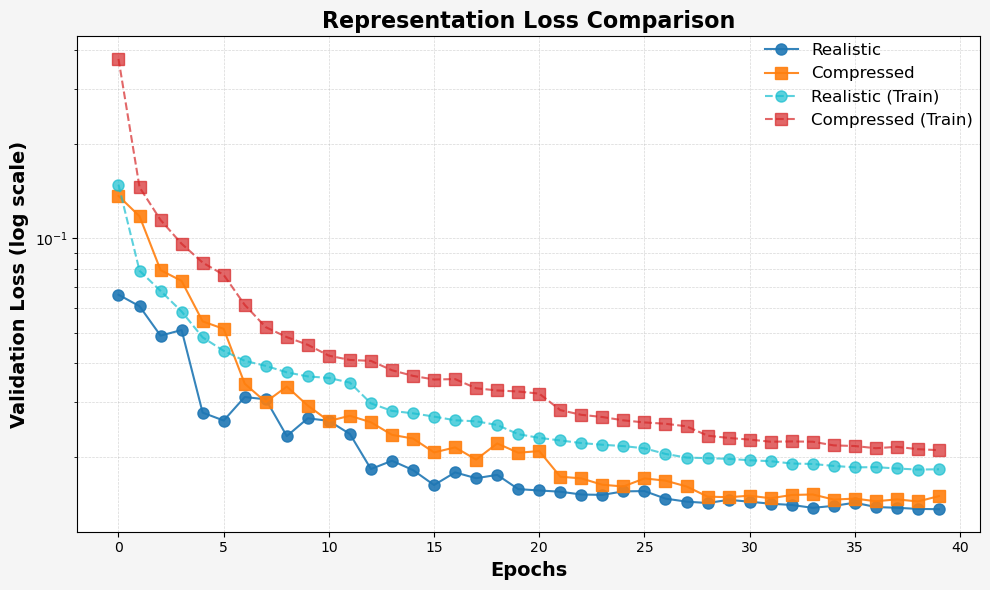

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Access each model's history
model1_history = history_realistic
model2_history = history_compressed

# Plotting the validation loss for all models
plt.figure(figsize=(10, 6))

# Refined color scheme and improved markers
plt.plot(model1_history['val_loss'], label='Realistic', color='#1f77b4', linestyle='-', marker='o', markersize=8, alpha=0.9)
plt.plot(model2_history['val_loss'], label='Compressed', color='#ff7f0e', linestyle='-', marker='s', markersize=8, alpha=0.9)
plt.plot(model1_history['loss'], label='Realistic (Train)', color='#17becf', linestyle='--', marker='o', markersize=8, alpha=0.7)
plt.plot(model2_history['loss'], label='Compressed (Train)', color='#d62728', linestyle='--', marker='s', markersize=8, alpha=0.7)

# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Representation Loss Comparison', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)


# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()
